In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from textutils import *

This notebook is an implementation of the approach described in this [essay](https://www.orphanalytics.com/en/news/whitepaper202012/OrphAnalyticsQAnon2020.pdf) and written about [here](https://www.prnewswire.com/news-releases/qanon-is-two-different-people-shows-machine-learning-analysis-from-orphanalytics-301192981.html).

It analyzes the posts of QAnon, and concludes that the messages are probably written by two persons instead of one.

From the last link:
>  QAnon has spread conspiracy theories to an unprecedentedly large audience. Its thousands of online messages have popularized narratives such as the existence of a child-trafficking deep state. Recently, it inspired a series of violent attacks and was listed as a terrorist threat by the FBI. The Swiss company OrphAnalytics just published an analysis of all messages posted by Q. Its patented technology aims at identifying authors of written documents. It has found two individual signals within the corpus of Q messages. Its new study contributes to revealing the origins and the persons behind one of the most impactful conspiracy theories in recent times.

We will replicate their analysis with "patented technoloy" with a simple sklearn approach.

## get the data

In [2]:
get_file('posts.json', "https://raw.githubusercontent.com/jkingsman/JSON-QAnon/main/posts.json")
data = pd.read_json("posts.json", orient='values')
data = pd.DataFrame([flatten_json(x) for x in data['posts']])[["post_metadata_source_site", "post_metadata_time", "text"]]

In [3]:
data.head()

,post_metadata_source_site,post_metadata_time,text
0,4ch,1509223468,>>147005381\nHRC extradition already in motion...
1,4ch,1509228948,"Mockingbird \nHRC detained, not arrested (yet)..."
2,4ch,1509292027,Open your eyes.\nIt finally came out that Rod/...
3,4ch,1509293500,"Some of us come here to drop crumbs, just crum..."
4,4ch,1509295638,"Follow the money, it’s the key.\nWhat is Pelos..."


## Clean up the timestamps

The text describes they used the analysis from [this](https://www.businessinsider.com/every-qanon-message-q-drop-analyzed-2020-10?international=true&r=US&IR=T) businessinsider article to bin the timeseries.

<img src="Qanon.png" width=450 height=400 />

These dates are hardcoded into the `bin_time` function imported from the `textutils.py`


In [4]:
data["time"] =pd.to_datetime(data["post_metadata_time"], unit="s")
data["time"] = data["time"].apply(lambda x : x.strftime("%Y-%m-%d"))
data["bintime"] = data["time"].apply(lambda x : bin_time(x))

Let's clean up the text some more. We will replace linebreaks ("\n") with spaces, remove urls and set everything to lowercase.

use the `remove_url` function from the textutils.

In [5]:
data["text"] = # your code
data["text"] = # your code
data["text"] = # your code

Now, we count every text and filter chuncks with size below 50.

In [6]:
data['size'] = # your code
data = data[data["size"] > 50]
data.reset_index(inplace=True, drop=True)

# Predictive model


In [7]:
from collections import Counter
count = Counter(data["post_metadata_source_site"])
count

Counter({'4ch': 182, '8ch': 1702, '8kun': 373})

The categories are unbalanced. We could try to make a predictive model. This is not something the paper did, but let's try. 

First, we will resample.

use a `.groupby` on the dataframe, and use `.sample` on that to sample the maximum "4ch" amount from the counter from every group, such that every group has an equal amount of samples.

In [8]:
downsampled = # your code

Use a tdidf

In [9]:
vectorizer = # your code
X = # your code
print(X.shape)

(546, 6134)


In [10]:
feats = vectorizer.get_feature_names()
np.random.choice(feats, size=10)

array(['destruction', 'wants', 'tv', 'sampling', '120', 'body',
       'insurgency', 'specialized', 'seattle', 'one'], dtype='<U59')

get the labels

In [11]:
y = downsampled["post_metadata_source_site"]

build a train-test split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape

((436, 6134), (110, 6134))

We get 5802 features. Let's test a simple model.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

# your code


print(clf.score(X_test, y_test))
confusion_matrix(y_test, yhat)

0.6545454545454545


array([[29,  4,  1],
       [ 5, 21,  6],
       [ 3, 19, 22]])

And try to remove some of the features, to see if this makes things better.
With PCA, we can reduce the dimensions such that we can account for 95% of the data.

In [14]:
pca = # your code
X_train = pca.fit_transform(X_train.todense())
X_test = pca.transform(X_test.todense())
X_train.shape, X_test.shape

((436, 370), (110, 370))

In [15]:
# fit and train the classifier on the reduced set

# your code
print(clf.score(X_test, y_test))
confusion_matrix(y_test, yhat)

0.6272727272727273


array([[28,  4,  2],
       [ 6, 21,  5],
       [ 3, 21, 20]])

The increase in performance is not that impressive. Sometimes it gets worse. However, we seem to be able to throw away about 90% of the features.

Maybe more complex models could do a better job. But let's go back to the paper we are trying to implement.

# Batching the text into 7k chuncks

In [17]:
data

,post_metadata_source_site,post_metadata_time,text,time,bintime,size
0,4ch,1509223468,>>147005381 hrc extradition already in motion ...,2017-10-28,0,403
1,4ch,1509228948,"mockingbird hrc detained, not arrested (yet)....",2017-10-28,0,1139
2,4ch,1509292027,open your eyes. it finally came out that rod/b...,2017-10-29,0,690
3,4ch,1509293500,"some of us come here to drop crumbs, just crum...",2017-10-29,0,910
4,4ch,1509295638,"follow the money, it’s the key. what is pelosi...",2017-10-29,0,889
...,...,...,...,...,...,...
2252,8kun,1603411052,">>11223081 only the beginning, padawan. they c...",2020-10-22,4,143
2253,8kun,1604184244,are you ready to finish what we started? 'noth...,2020-10-31,4,105
2254,8kun,1604184408,are you ready to hold the political elite [pro...,2020-10-31,4,68
2255,8kun,1604184566,are you ready to take back control of this cou...,2020-10-31,4,53


In [18]:
def batch_seq(text, k):
	longseq = " ".join(text)
	n = int(len(longseq) / k)
	parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
	return parts, n


The paper describes batching all the text into chunks of 7500 characters. We can obtain sort of the same by splitting the text up into 100 batches, 7.7k each.

In [19]:
z=100
parts, n = batch_seq(data["text"], k=z)
parts = parts[:-1]
len(parts), n

(100, 7710)

Let's keep track of which datapoint belongs to which batch

In [20]:
data['group'] = data["size"].cumsum() // n

In [21]:
data

,post_metadata_source_site,post_metadata_time,text,time,bintime,size,group
0,4ch,1509223468,>>147005381 hrc extradition already in motion ...,2017-10-28,0,403,0
1,4ch,1509228948,"mockingbird hrc detained, not arrested (yet)....",2017-10-28,0,1139,0
2,4ch,1509292027,open your eyes. it finally came out that rod/b...,2017-10-29,0,690,0
3,4ch,1509293500,"some of us come here to drop crumbs, just crum...",2017-10-29,0,910,0
4,4ch,1509295638,"follow the money, it’s the key. what is pelosi...",2017-10-29,0,889,0
...,...,...,...,...,...,...,...
2252,8kun,1603411052,">>11223081 only the beginning, padawan. they c...",2020-10-22,4,143,99
2253,8kun,1604184244,are you ready to finish what we started? 'noth...,2020-10-31,4,105,99
2254,8kun,1604184408,are you ready to hold the political elite [pro...,2020-10-31,4,68,99
2255,8kun,1604184566,are you ready to take back control of this cou...,2020-10-31,4,53,99


The paper uses a ngram with size 3 on characterlevel. We can do that with `CountVectorizer`

In [22]:
vectorizer = # your code
X = vectorizer.fit_transform(parts)
X

<100x23065 sparse matrix of type '<class 'numpy.int64'>'
	with 247786 stored elements in Compressed Sparse Row format>

And calculates the pairwise manhattan distances. That way, we get an idea how how different every chunk is, when compared to all other chunks, in terms of the ngrams.

In [23]:
from sklearn.metrics.pairwise import manhattan_distances
X = X.todense()
distance = # your code

To handle the labels, we make integers of the labels.

In [24]:
labels = np.unique(data.post_metadata_source_site)
mapping = {labels[i]:i for i in range(3)}
data["source"] = data["post_metadata_source_site"].apply(lambda x : mapping[x])

Because we have integers, we can round the groups. This way, we can handle chunks of 7.7k characters that are partly in one group, and partly in another.

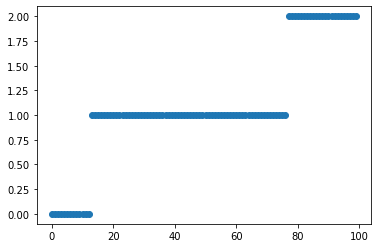

In [25]:
sourcemean = np.round(data.groupby("group").source.mean()).values.reshape(-1,1)
plt.scatter(range(z), sourcemean)

And to the same for the timebins.

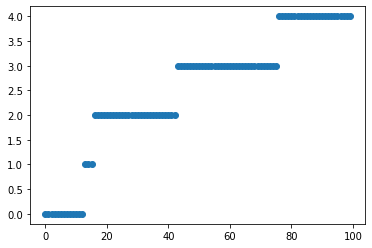

In [28]:
timemean = np.round(data.groupby("group").bintime.mean()).values.reshape(-1,1)

plt.scatter(range(z), timemean)
plt.show()

## PCA
We will now reduce the dimensionality to 2 components with PCA.

In [29]:
pca = # your code
model = pca.fit_transform(distance)

and concatenate everything together into one dataframe.

In [30]:
p = pd.DataFrame(np.concatenate([model, sourcemean, timemean], axis=1), columns=["x", "y", "source", "time"]).reset_index()
p["time"] = p["time"].astype(int)
p

,index,x,y,source,time
0,0,-4962.117759,4689.010764,0.0,0
1,1,-6779.553386,5011.369897,0.0,0
2,2,-6687.795765,4005.028966,0.0,0
3,3,-6141.775227,5703.902465,0.0,0
4,4,-5655.252860,4399.479831,0.0,0
...,...,...,...,...,...
95,95,442.229817,-2681.537909,2.0,4
96,96,8348.465632,-1460.042371,2.0,4
97,97,-1002.431624,-1100.965354,2.0,4
98,98,-276.928766,-435.848472,2.0,4


## Plot
With all this, we can start plotting. 
First, a scatterplot with the source as hue.

<AxesSubplot:xlabel='x', ylabel='y'>

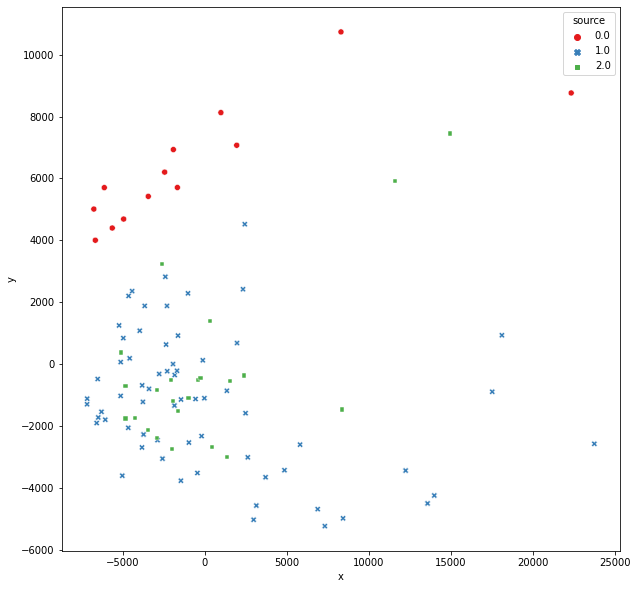

In [31]:
# your code

This reproduces the main conclusion, that the red source is not overlapping with the other two sources.

Of course, this tells you nothing about how high the chance is, that this is actually caused by having two authors, or by somehow changing the writing style.

For that, we would need access to how likely it is that the writing style changes this much.

However, we still have reproduced their "patented technology" with a few lines of code.

Let's try a kde plot. use sns.joinplot with `kind="kde"

<Figure size 1080x1080 with 0 Axes>

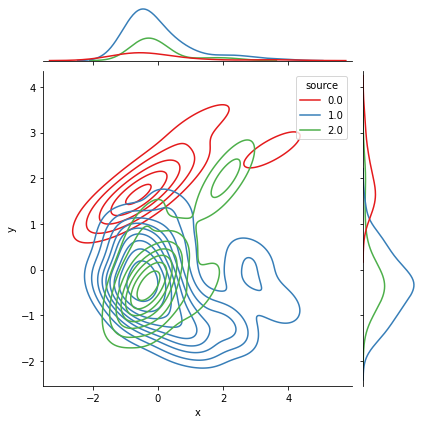

In [19]:
plt.figure(figsize=(15,15))
# your code

And lets use the time as hue.

<AxesSubplot:xlabel='x', ylabel='y'>

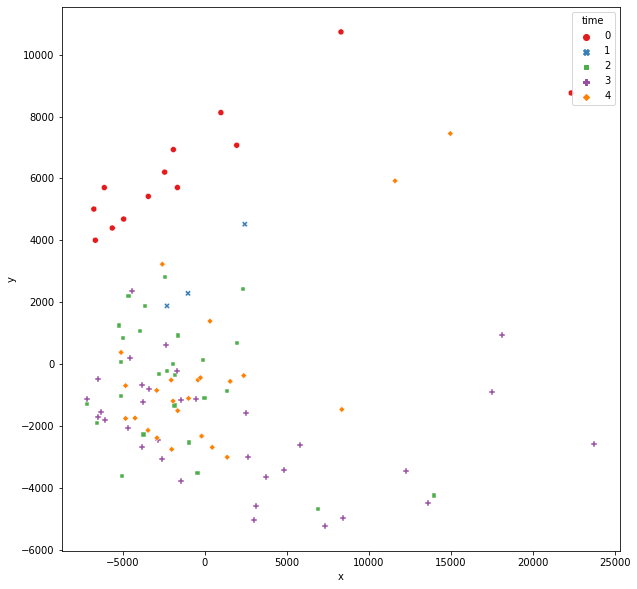

In [32]:
plt.figure(figsize=(10,10))
# your code

Maybe a facet plot, combining source als col and time as hue.

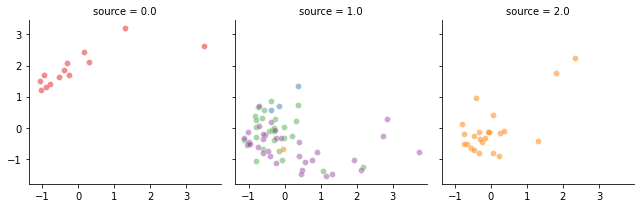

In [22]:
# your code